In [1]:
from ultralytics import YOLO
import cv2
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import mediapipe as mp
import os

In [2]:
model = YOLO('yolo11s.pt')
model.export(format='onnx')

Ultralytics 8.3.146  Python-3.10.9 torch-2.7.0+cpu CPU (Intel Core(TM) i9-9980HK 2.40GHz)
 ProTip: Export to OpenVINO format for best performance on Intel CPUs. Learn more at https://docs.ultralytics.com/integrations/openvino/
YOLO11s summary (fused): 100 layers, 9,443,760 parameters, 0 gradients, 21.5 GFLOPs

PyTorch: starting from 'yolo11s.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (18.4 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.53', 'onnxruntime'] not found, attempting AutoUpdate...
     --------------------------------------- 14.5/14.5 MB 65.1 MB/s eta 0:00:00
     ---------------------------------------- 164.6/164.6 kB ? eta 0:00:00
     --------------------------------------- 12.7/12.7 MB 81.8 MB/s eta 0:00:00
     ---------------------------------------- 46.0/46.0 kB ? eta 0:00:00
     ---------------------------------------- 86.8/86.8 kB ? eta 0:00:00
     ---------------------------------------- 83.2/83

'yolo11s.onnx'

In [3]:
def process_video(video_path, n_frames=0, min_movement=5, idle_threshold=2):
    model = YOLO("yolov8n.pt")
    cap = cv2.VideoCapture(video_path)

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    detections = []
    frame_idx = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        results = model.track(frame, persist=True, classes=[0], tracker="bytetrack.yaml", verbose=False)
        if results[0].boxes.id is not None:
            boxes = results[0].boxes.xyxy.cpu().numpy()
            ids = results[0].boxes.id.cpu().numpy()
            for box, track_id in zip(boxes, ids):
                x1, y1, x2, y2 = box
                center_y = (y1 + y2) / 2
                detections.append({
                    "frame": frame_idx,
                    "id": int(track_id),
                    "bbox": box,
                    "center_y": center_y
                })

                cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
                cv2.putText(frame, f'ID: {int(track_id)}', (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        cv2.putText(frame, f"Frame: {frame_idx}", (10, frame_height -10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
        cv2.imshow("Tracking", frame)
        key = cv2.waitKey(30)
        if key == ord('q'):
            break
        frame_idx += 1

    cap.release()
    cv2.destroyAllWindows()

    # Step 1: Focus on the most frequent person ID
    id_counts = Counter(d['id'] for d in detections)
    main_id = id_counts.most_common(1)[0][0]
    track = [d for d in detections if d['id'] == main_id]

    # Step 2: Find motion start (where movement begins)
    start_frame = track[0]["frame"]
    for i in range(1, len(track)):
        prev_y = track[i-1]["center_y"]
        curr_y = track[i]["center_y"]
        if abs(curr_y - prev_y) > min_movement:
            start_frame = track[i]["frame"]
            break

    # Step 3: Find vanish point (last frame near bottom)
    bottom_threshold = 0.9 * frame_height
    vanish_frame = None
    for i in reversed(range(len(track))):
        y1, y2 = track[i]["bbox"][1], track[i]["bbox"][3]
        if y2 > bottom_threshold:
            vanish_frame = track[i]["frame"]
            break

    # Check for stopping in place
    idle_end_frame = track[-1]["frame"]
    for i in reversed(range(1, len(track))):
        if abs(track[i]["center_y"] - track[i-1]["center_y"]) > min_movement:
            idle_end_frame = track[i]["frame"]
            break
    idle_end_frame = max(start_frame, idle_end_frame+1)

    # If person vanishes (past bottom threshold), include one frame after detection
    end_frame = idle_end_frame
    if vanish_frame is not None and vanish_frame >= idle_end_frame:
        end_frame = vanish_frame + 1
    
    end_frame = min(end_frame, total_frames - 1)

    # Step 4: Extract the frames
    cap = cv2.VideoCapture(video_path)
    selected_frames = []
    frames_to_grap = np.linspace(start_frame, end_frame, n_frames, dtype=int)
    current_idx = 0
    grab_idx_set = set(frames_to_grap)

    while cap.isOpened() and current_idx <= end_frame:
        ret, frame = cap.read()
        if not ret:
            break
        if current_idx in grab_idx_set:
            selected_frames.append(frame)
        current_idx += 1

    cap.release()
    return selected_frames

In [43]:
side_video_paths= [
    "C:/Users/hanna/Documents/Thesis/datainsamling/data/side_enter/side_enter_2.mp4",
    "C:/Users/hanna/Documents/Thesis/datainsamling/data/side_enter/side_enter_4.mp4",
    "C:/Users/hanna/Documents/Thesis/datainsamling/data/side_enter/side_enter_6.mp4",
    "C:/Users/hanna/Documents/Thesis/datainsamling/data/side_enter/side_enter_8.mp4",
    "C:/Users/hanna/Documents/Thesis/datainsamling/data/side_enter/side_enter_10.mp4",
    "C:/Users/hanna/Documents/Thesis/datainsamling/data/side_enter/side_enter_12.mp4",
    "C:/Users/hanna/Documents/Thesis/datainsamling/data/side_enter/side_enter_14.mp4",
    "C:/Users/hanna/Documents/Thesis/datainsamling/data/side_enter/side_enter_16.mp4",
    "C:/Users/hanna/Documents/Thesis/datainsamling/data/side_enter/side_enter_18.mp4",
    "C:/Users/hanna/Documents/Thesis/datainsamling/data/side_enter/side_enter_20.mp4"
]
side_video_vanish_frames = [129, ]

front_video_paths = [
    "C:/Users/hanna/Documents/Thesis/datainsamling/data/front_enter/front_enter_2.mp4",
    "C:/Users/hanna/Documents/Thesis/datainsamling/data/front_enter/front_enter_4.mp4",
    "C:/Users/hanna/Documents/Thesis/datainsamling/data/front_enter/front_enter_6.mp4",
    "C:/Users/hanna/Documents/Thesis/datainsamling/data/front_enter/front_enter_8.mp4",
    "C:/Users/hanna/Documents/Thesis/datainsamling/data/front_enter/front_enter_11.mp4",
    "C:/Users/hanna/Documents/Thesis/datainsamling/data/front_enter/front_enter_12.mp4",
    "C:/Users/hanna/Documents/Thesis/datainsamling/data/front_enter/front_enter_14.mp4",
    "C:/Users/hanna/Documents/Thesis/datainsamling/data/front_enter/front_enter_16.mp4",
    "C:/Users/hanna/Documents/Thesis/datainsamling/data/front_enter/front_enter_18.mp4",
    "C:/Users/hanna/Documents/Thesis/datainsamling/data/front_enter/front_enter_20.mp4"
]

In [ ]:
s

In [26]:
def show_frame(videos, start_frame = 0):
    marked_frames = {}

    for video_path in videos:
        video_name = os.path.basename(video_path)
        print(f"Processing video: {video_name}")

        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_number = 0
        selected_frame = None

        while True:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
            ret, frame = cap.read()
            if not ret:
                print(f"Could not read frame {frame_number} from {video_name}")
                break

            display = frame.copy()
            cv2.putText(display, f"{video_name} | Frame: {frame_number}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.imshow("Frame viewer", display)

            key = cv2.waitKey(0) & 0xFF
            
            if key == ord('d'):
                frame_number = min(frame_number + 1, total_frames - 1)
            elif key == ord('a'):
                frame_number = max(frame_number - 1, 0)
            elif key in [13, ord('e')]:
                selected_frame = frame_number
                print(f"Marked frame {selected_frame} in {video_name}")
                break
            elif key == ord('q'):
                print("Quit requested")
                cap.release()
                cv2.destroyAllWindows()
                return marked_frames
            
        cap.release()
        cv2.destroyAllWindows()

        if selected_frame is not None:
            marked_frames[video_name] = selected_frame

    return marked_frames



In [ ]:
side_enter_videos = show_frame(side_video_paths)


Processing video: side_enter_2.mp4
Marked frame 129 in side_enter_2.mp4
Processing video: side_enter_4.mp4
Marked frame 84 in side_enter_4.mp4
Processing video: side_enter_6.mp4
Marked frame 141 in side_enter_6.mp4
Processing video: side_enter_8.mp4
Marked frame 143 in side_enter_8.mp4
Processing video: side_enter_10.mp4
Marked frame 123 in side_enter_10.mp4
Processing video: side_enter_12.mp4
Marked frame 128 in side_enter_12.mp4
Processing video: side_enter_14.mp4
Marked frame 121 in side_enter_14.mp4
Processing video: side_enter_16.mp4
Marked frame 122 in side_enter_16.mp4
Processing video: side_enter_18.mp4
Marked frame 127 in side_enter_18.mp4
Processing video: side_enter_20.mp4
Marked frame 123 in side_enter_20.mp4
Processing video: front_enter_2.mp4
Marked frame 130 in front_enter_2.mp4
Processing video: front_enter_4.mp4
Marked frame 147 in front_enter_4.mp4
Processing video: front_enter_6.mp4
Marked frame 129 in front_enter_6.mp4
Processing video: front_enter_8.mp4
Marked fram

In [44]:
front_enter_videos = show_frame(front_video_paths)

Processing video: front_enter_2.mp4
Marked frame 130 in front_enter_2.mp4
Processing video: front_enter_4.mp4
Marked frame 147 in front_enter_4.mp4
Processing video: front_enter_6.mp4
Marked frame 129 in front_enter_6.mp4
Processing video: front_enter_8.mp4
Marked frame 134 in front_enter_8.mp4
Processing video: front_enter_11.mp4
Marked frame 137 in front_enter_11.mp4
Processing video: front_enter_12.mp4
Marked frame 133 in front_enter_12.mp4
Processing video: front_enter_14.mp4
Marked frame 142 in front_enter_14.mp4
Processing video: front_enter_16.mp4
Marked frame 139 in front_enter_16.mp4
Processing video: front_enter_18.mp4
Marked frame 105 in front_enter_18.mp4
Processing video: front_enter_20.mp4
Marked frame 99 in front_enter_20.mp4


In [10]:
def detected_frames_YOLO(video_path, model=None):
    if model == None:
        model = YOLO("yolov8n.pt")
    
    cap = cv2.VideoCapture(video_path)
    frame_idx = 0
    detected_frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        results = model.track(frame, persist=True, classes=[0], tracker="bytetrack.yaml", verbose=False)
        if results[0].boxes.id is not None:
            detected_frames.append(frame_idx)

        frame_idx += 1
    
    cap.release()
    return total_frames, detected_frames


In [72]:
def detected_frames_mediapipe(video_path):
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.6)
    
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    detected_frames = []
    frame_idx = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(frame_rgb)

        if results.pose_landmarks:
            detected_frames.append(frame_idx)
        
        frame_idx += 1
    
    cap.release()
    pose.close()
    return total_frames, detected_frames

In [49]:
def build_detection_dict(video_paths, true_end_dict, detection_function, yolo_model=None):
    detection_summary = {}

    for i, video_path in enumerate(video_paths):
        video_name = os.path.basename(video_path)
        print(f"[{i+1}/{len(video_paths)}] Processing {video_name}...")

        if video_name not in true_end_dict:
            print(f"Warning: {video_name} not found in true_end_dict, skipping.")
            continue

        true_end_frame = true_end_dict[video_name]
        if yolo_model:
            total_frames, detected_frames = detection_function(video_path, model=yolo_model)
        else:
            total_frames, detected_frames = detection_function(video_path)

        detection_summary[video_name] = {
            "total_frames": total_frames,
            "detected_frames": detected_frames,
            "true_end_frame": true_end_frame
        }
    print("Done with all videos for this scenario.")
    return detection_summary
            

In [ ]:
yolov8n_detection_dict_side = build_detection_dict(
    side_video_paths,
    side_enter_videos,
    detected_frames_YOLO
)

yolov8n_detection_dict_front = build_detection_dict(
    front_video_paths,
    front_enter_videos,
    detected_frames_YOLO
)

mediapipe_5_detection_dict_side = build_detection_dict(
    side_video_paths,
    side_enter_videos,
    detected_frames_mediapipe
)

mediapipe_5_detection_dict_front = build_detection_dict(
    front_video_paths,
    front_enter_videos,
    detected_frames_mediapipe
)

[1/10] Processing side_enter_2.mp4...
[2/10] Processing side_enter_4.mp4...
[3/10] Processing side_enter_6.mp4...
[4/10] Processing side_enter_8.mp4...
[5/10] Processing side_enter_10.mp4...
[6/10] Processing side_enter_12.mp4...
[7/10] Processing side_enter_14.mp4...
[8/10] Processing side_enter_16.mp4...
[9/10] Processing side_enter_18.mp4...
[10/10] Processing side_enter_20.mp4...
Done with all videos for this scenario.
[1/10] Processing front_enter_2.mp4...
[2/10] Processing front_enter_4.mp4...
[3/10] Processing front_enter_6.mp4...
[4/10] Processing front_enter_8.mp4...
[5/10] Processing front_enter_11.mp4...
[6/10] Processing front_enter_12.mp4...
[7/10] Processing front_enter_14.mp4...
[8/10] Processing front_enter_16.mp4...
[9/10] Processing front_enter_18.mp4...
[10/10] Processing front_enter_20.mp4...
Done with all videos for this scenario.
[1/10] Processing side_enter_2.mp4...
[2/10] Processing side_enter_4.mp4...
[3/10] Processing side_enter_6.mp4...
[4/10] Processing side

In [70]:
yolov8m_detection_dict_side = build_detection_dict(
    side_video_paths,
    side_enter_videos,
    detected_frames_YOLO,
    yolo_model=YOLO("yolov8m.pt")
)

yolov8m_detection_dict_front = build_detection_dict(
    front_video_paths,
    front_enter_videos,
    detected_frames_YOLO,
    yolo_model=YOLO("yolov8m.pt")
)

mediapipe_7_detection_dict_side = build_detection_dict(
    side_video_paths,
    side_enter_videos,
    detected_frames_mediapipe
)

mediapipe_7_detection_dict_front = build_detection_dict(
    front_video_paths,
    front_enter_videos,
    detected_frames_mediapipe
)

100%|██████████| 49.7M/49.7M [00:00<00:00, 79.3MB/s]


[1/10] Processing side_enter_2.mp4...
[2/10] Processing side_enter_4.mp4...
[3/10] Processing side_enter_6.mp4...
[4/10] Processing side_enter_8.mp4...
[5/10] Processing side_enter_10.mp4...
[6/10] Processing side_enter_12.mp4...
[7/10] Processing side_enter_14.mp4...
[8/10] Processing side_enter_16.mp4...
[9/10] Processing side_enter_18.mp4...
[10/10] Processing side_enter_20.mp4...
Done with all videos for this scenario.
[1/10] Processing front_enter_2.mp4...
[2/10] Processing front_enter_4.mp4...
[3/10] Processing front_enter_6.mp4...
[4/10] Processing front_enter_8.mp4...
[5/10] Processing front_enter_11.mp4...
[6/10] Processing front_enter_12.mp4...
[7/10] Processing front_enter_14.mp4...
[8/10] Processing front_enter_16.mp4...
[9/10] Processing front_enter_18.mp4...
[10/10] Processing front_enter_20.mp4...
Done with all videos for this scenario.
[1/10] Processing side_enter_2.mp4...
[2/10] Processing side_enter_4.mp4...
[3/10] Processing side_enter_6.mp4...
[4/10] Processing side

In [73]:
yolov8s_detection_dict_side = build_detection_dict(
    side_video_paths,
    side_enter_videos,
    detected_frames_YOLO,
    yolo_model=YOLO("yolov8s.pt")
)

yolov8s_detection_dict_front = build_detection_dict(
    front_video_paths,
    front_enter_videos,
    detected_frames_YOLO,
    yolo_model=YOLO("yolov8s.pt")
)

mediapipe_6_detection_dict_side = build_detection_dict(
    side_video_paths,
    side_enter_videos,
    detected_frames_mediapipe
)

mediapipe_6_detection_dict_front = build_detection_dict(
    front_video_paths,
    front_enter_videos,
    detected_frames_mediapipe
)

100%|██████████| 21.5M/21.5M [00:00<00:00, 58.0MB/s]


[1/10] Processing side_enter_2.mp4...
[2/10] Processing side_enter_4.mp4...
[3/10] Processing side_enter_6.mp4...
[4/10] Processing side_enter_8.mp4...
[5/10] Processing side_enter_10.mp4...
[6/10] Processing side_enter_12.mp4...
[7/10] Processing side_enter_14.mp4...
[8/10] Processing side_enter_16.mp4...
[9/10] Processing side_enter_18.mp4...
[10/10] Processing side_enter_20.mp4...
Done with all videos for this scenario.
[1/10] Processing front_enter_2.mp4...
[2/10] Processing front_enter_4.mp4...
[3/10] Processing front_enter_6.mp4...
[4/10] Processing front_enter_8.mp4...
[5/10] Processing front_enter_11.mp4...
[6/10] Processing front_enter_12.mp4...
[7/10] Processing front_enter_14.mp4...
[8/10] Processing front_enter_16.mp4...
[9/10] Processing front_enter_18.mp4...
[10/10] Processing front_enter_20.mp4...
Done with all videos for this scenario.
[1/10] Processing side_enter_2.mp4...
[2/10] Processing side_enter_4.mp4...
[3/10] Processing side_enter_6.mp4...
[4/10] Processing side

In [65]:
def plot_detection_summary(detection_dict, title):
    video_names = list(detection_dict.keys())
    num_videos = len(video_names)

    plt.figure(figsize=(12, 0.6 * num_videos))

    for idx, video_name in enumerate(video_names):
        data = detection_dict[video_name]
        y_pos = num_videos-idx

        detected = data["detected_frames"]
        plt.scatter(detected, [y_pos] * len(detected), color='blue', s=5, label='Detected Frames' if idx == 0 else "")

        plt.scatter([data["true_end_frame"]], [y_pos], color='red', s=40, marker='x', label='True End Frame' if idx == 0 else "")

        plt.text(-10, y_pos, video_name, ha='right', va='center', fontsize=8)

    plt.xlabel("Frame Index")
    plt.yticks([])
    plt.title(title)
    plt.legend(loc='upper right')
    plt.grid(True, axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

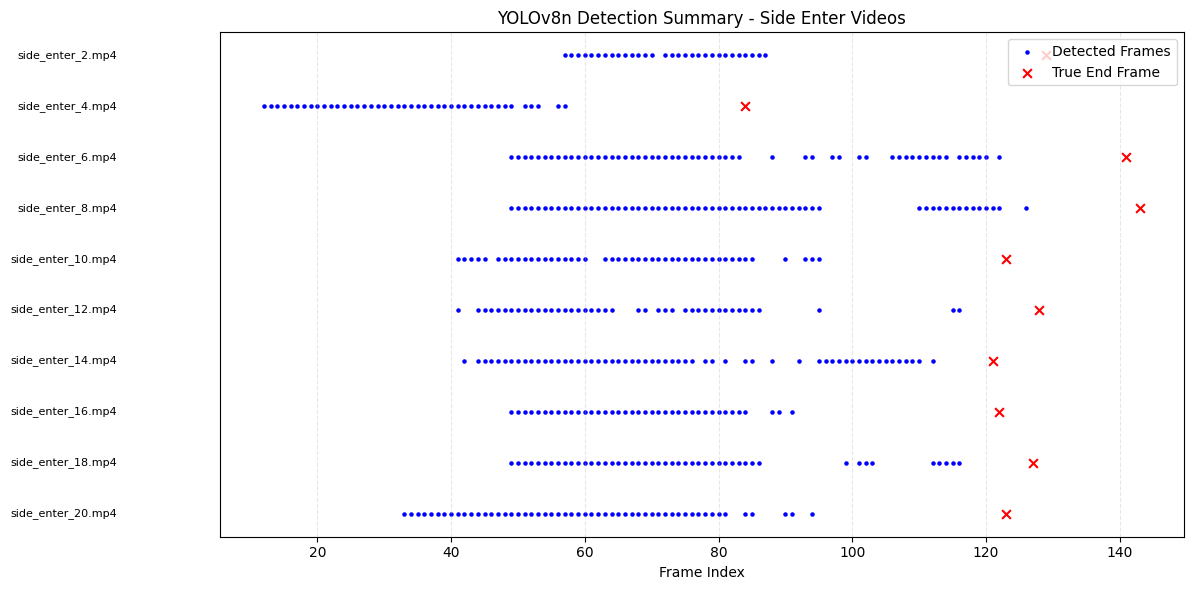

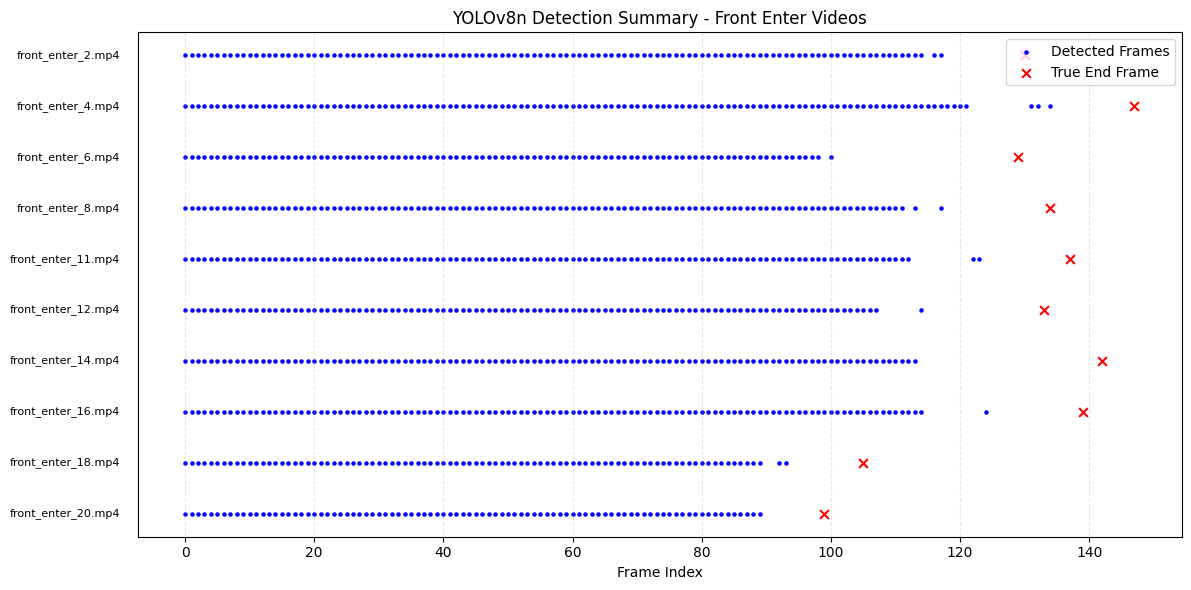

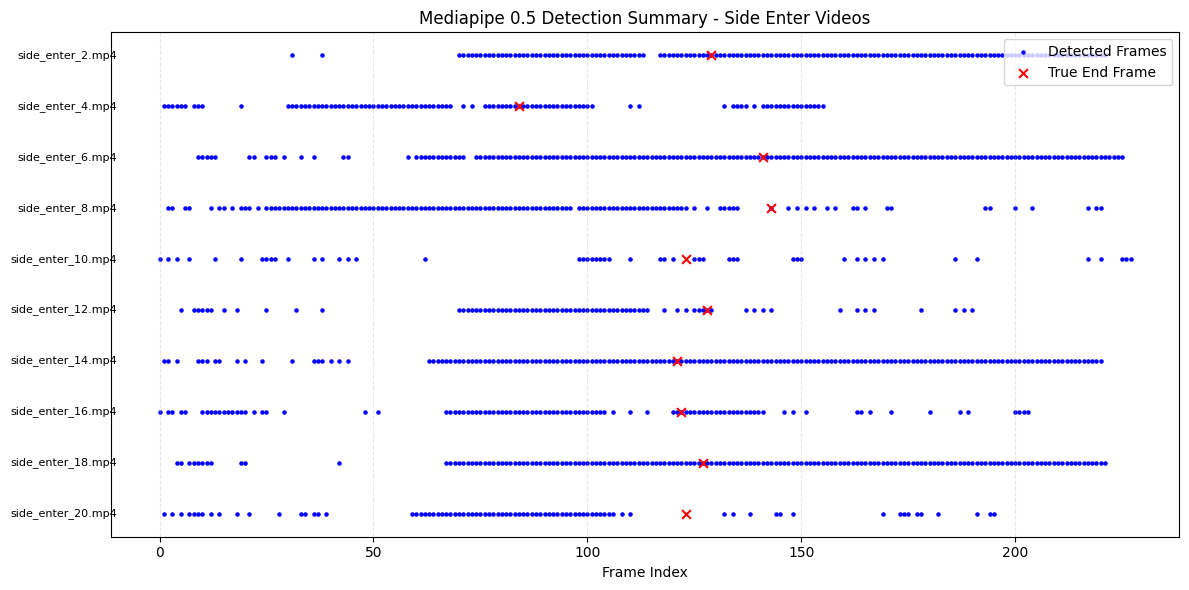

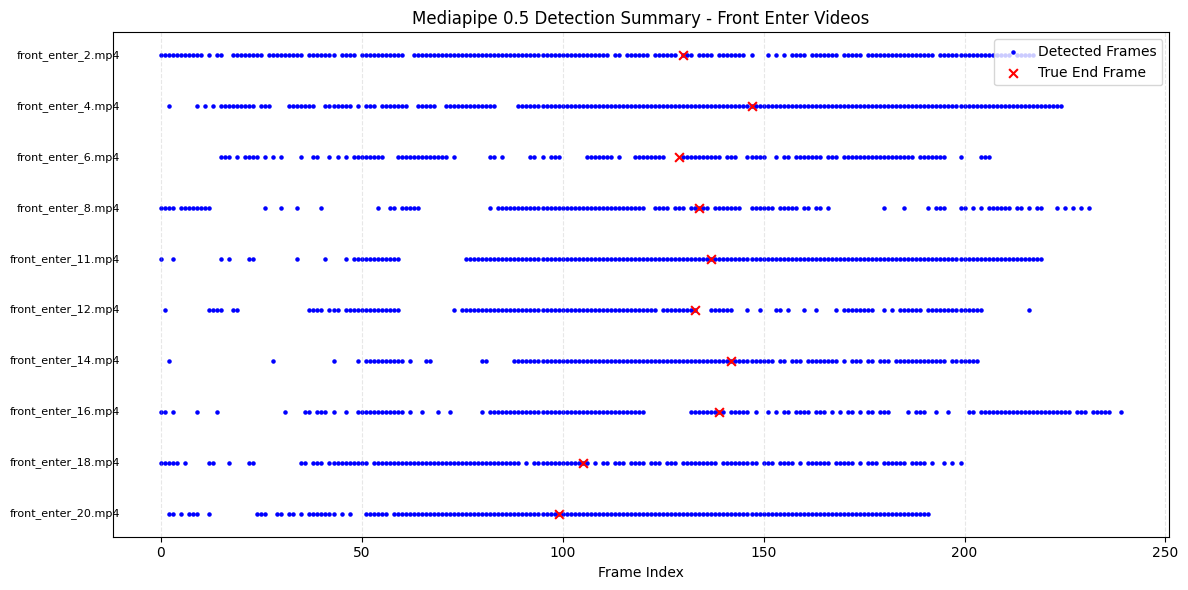

In [ ]:
plot_detection_summary(yolov8n_detection_dict_side, "YOLOv8n Detection Summary - Side Enter Videos")
plot_detection_summary(yolov8n_detection_dict_front, "YOLOv8n Detection Summary - Front Enter Videos")
plot_detection_summary(mediapipe_5_detection_dict_side, "Mediapipe 0.5 Detection Summary - Side Enter Videos")
plot_detection_summary(mediapipe_5_detection_dict_front, "Mediapipe 0.5 Detection Summary - Front Enter Videos")

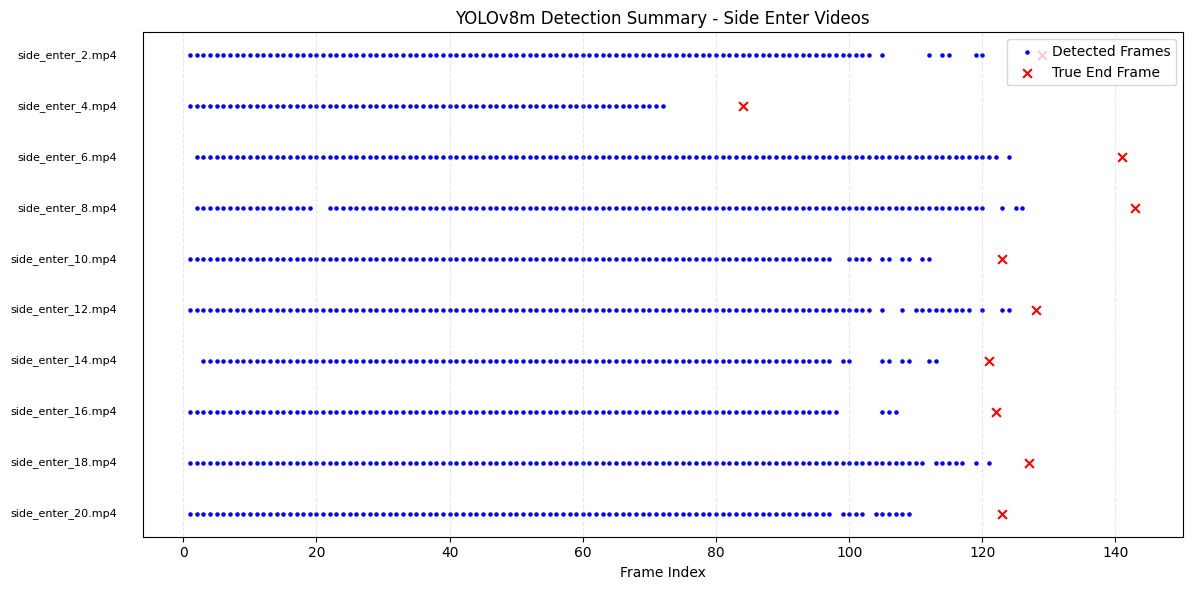

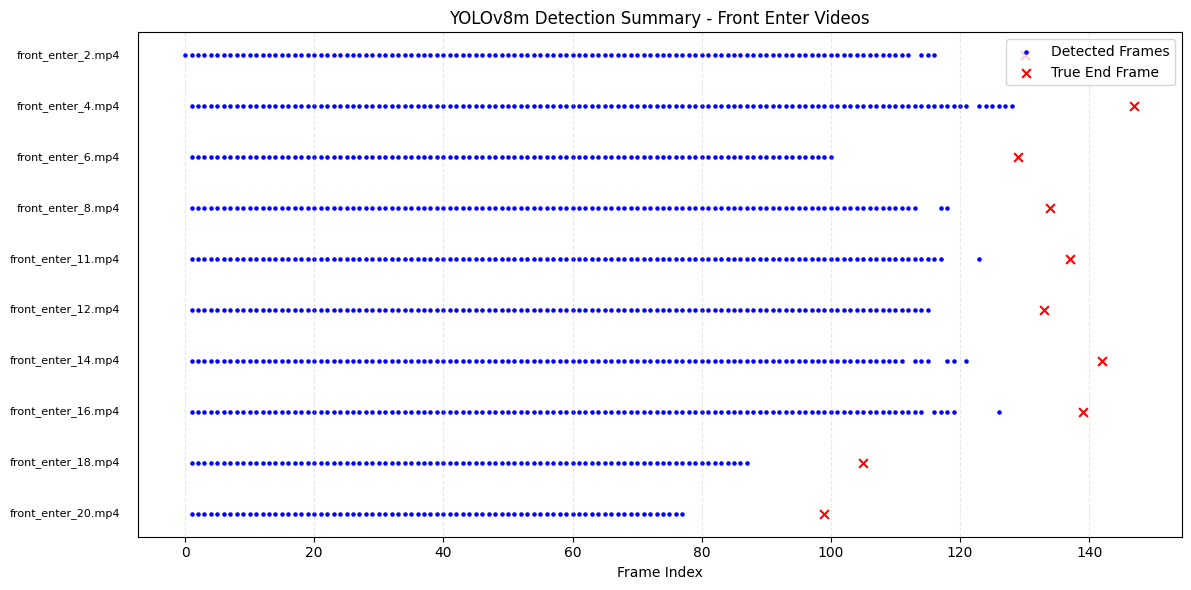

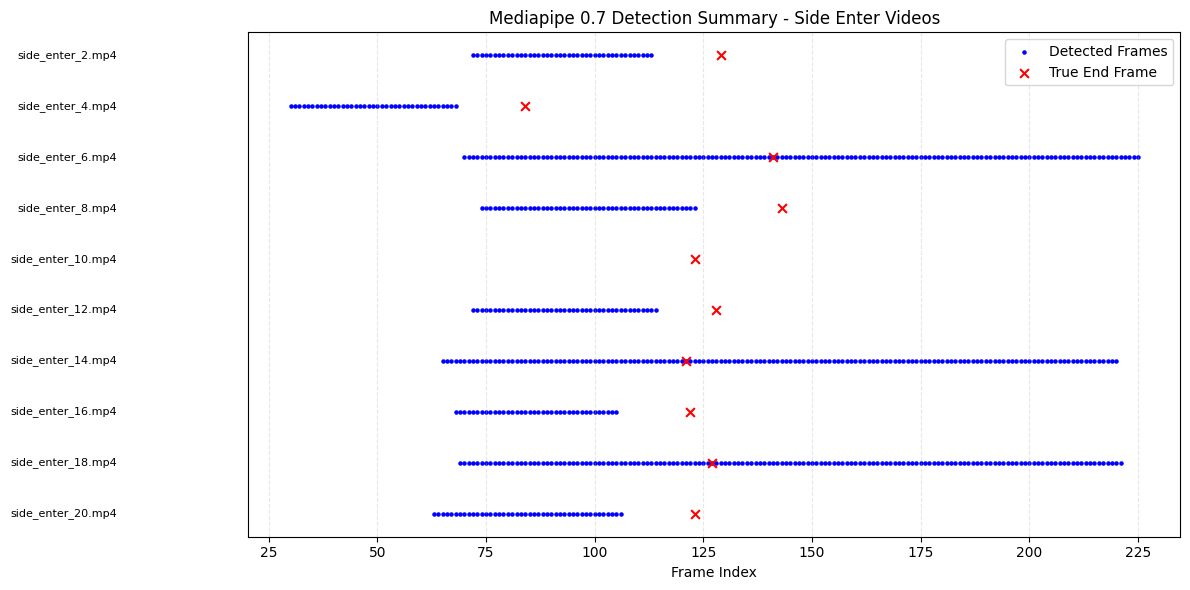

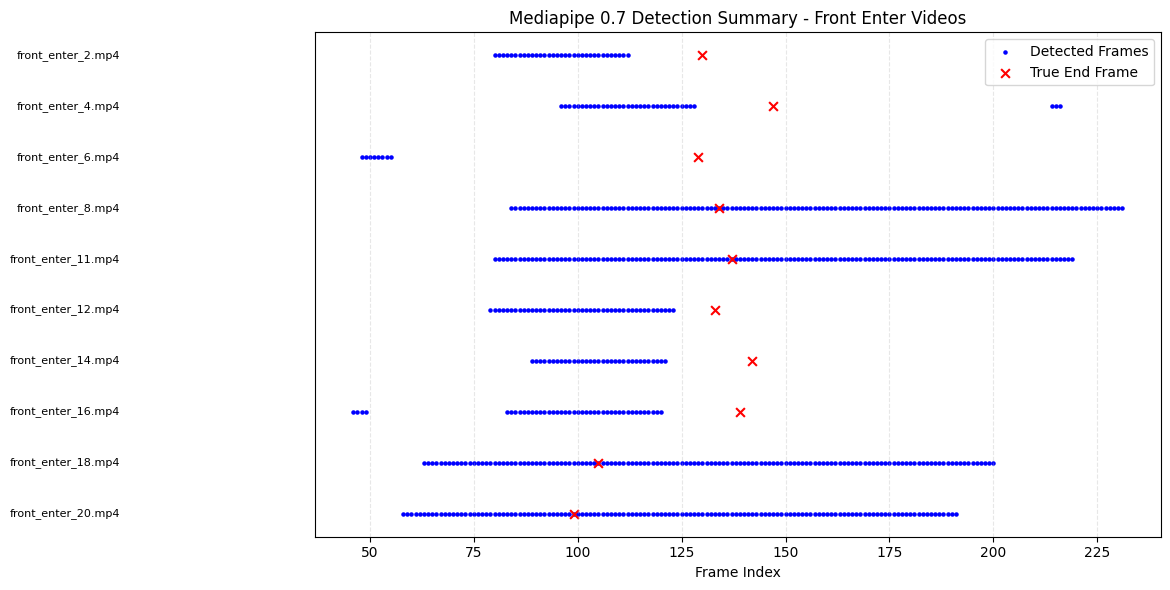

In [71]:
plot_detection_summary(yolov8m_detection_dict_side, "YOLOv8m Detection Summary - Side Enter Videos")
plot_detection_summary(yolov8m_detection_dict_front, "YOLOv8m Detection Summary - Front Enter Videos")
plot_detection_summary(mediapipe_7_detection_dict_side, "Mediapipe 0.7 Detection Summary - Side Enter Videos")
plot_detection_summary(mediapipe_7_detection_dict_front, "Mediapipe 0.7 Detection Summary - Front Enter Videos")

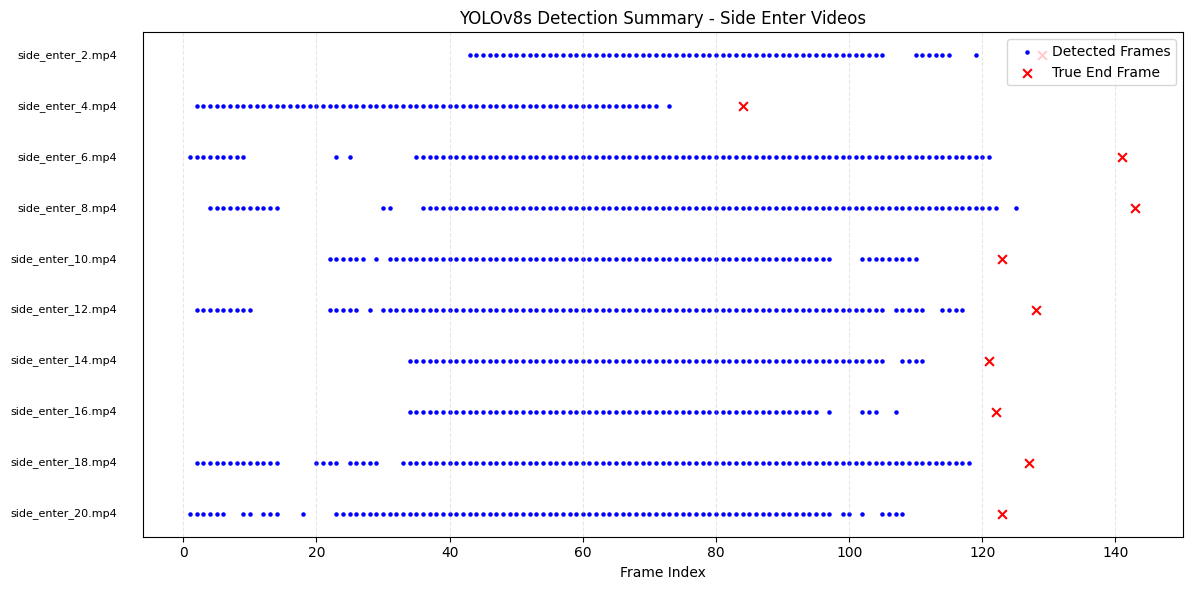

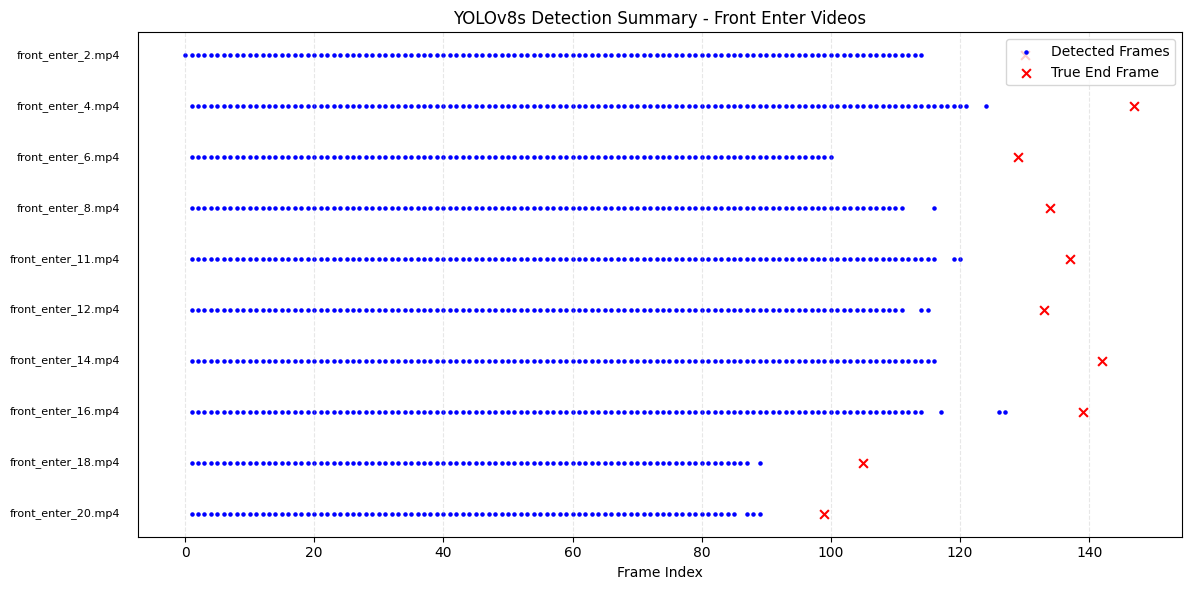

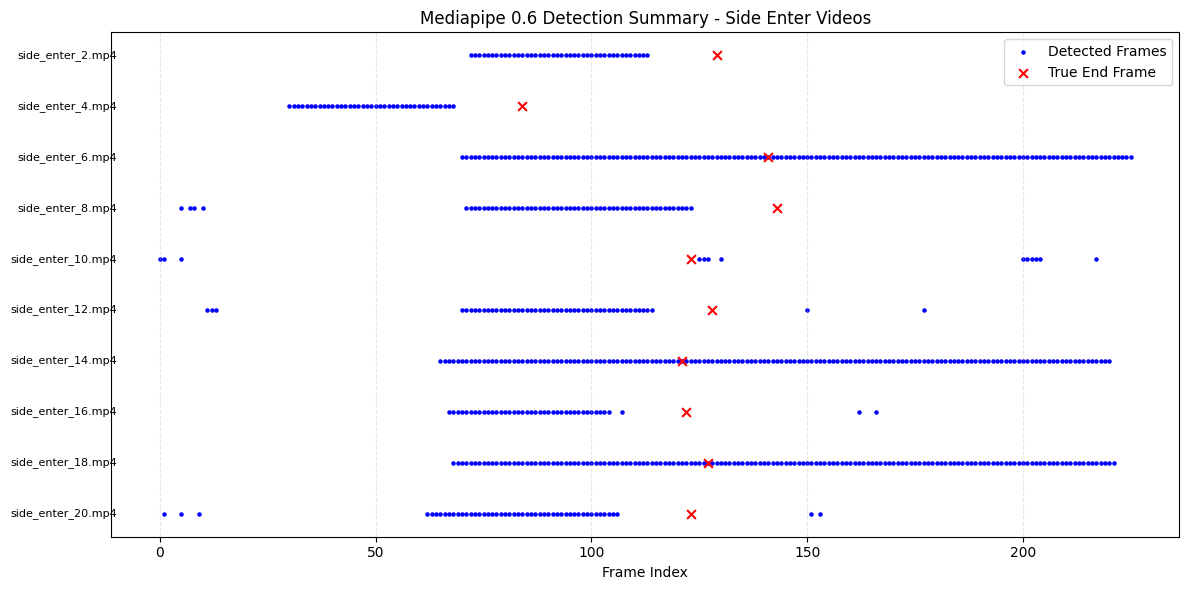

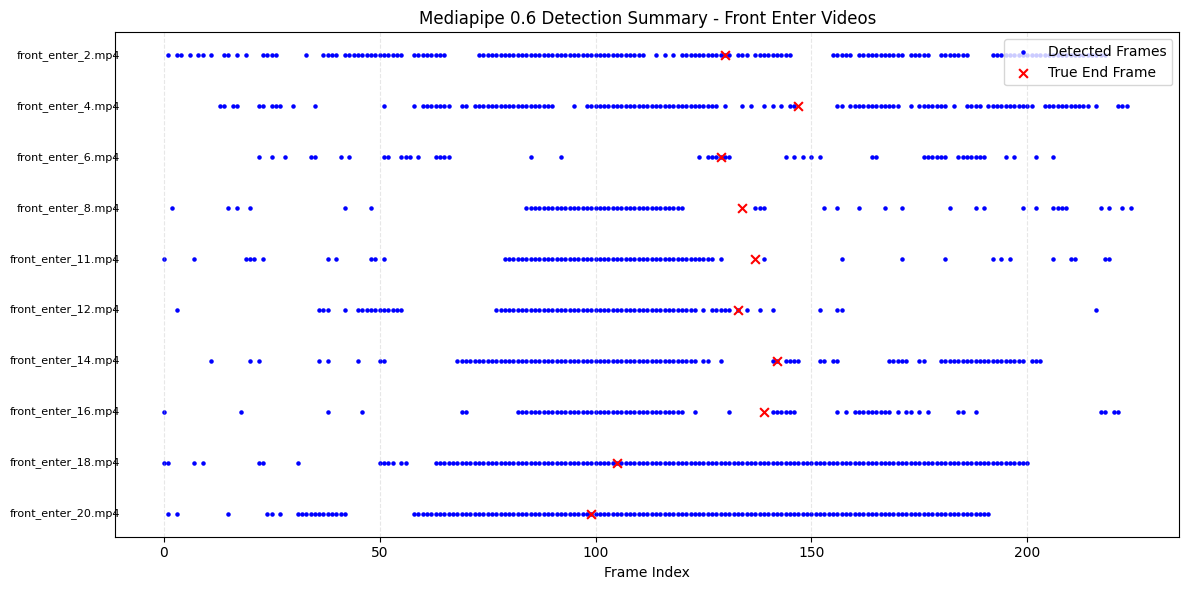

In [74]:
plot_detection_summary(yolov8s_detection_dict_side, "YOLOv8s Detection Summary - Side Enter Videos")
plot_detection_summary(yolov8s_detection_dict_front, "YOLOv8s Detection Summary - Front Enter Videos")
plot_detection_summary(mediapipe_6_detection_dict_side, "Mediapipe 0.6 Detection Summary - Side Enter Videos")
plot_detection_summary(mediapipe_6_detection_dict_front, "Mediapipe 0.6 Detection Summary - Front Enter Videos")

In [58]:
def visualize_mediapipe_pose_video(video_path,
                                   min_detection_confidence=0.5,
                                   min_tracking_confidence=0.5):
    mp_pose = mp.solutions.pose
    mp_drawing = mp.solutions.drawing_utils

    pose = mp_pose.Pose(
        static_image_mode=False,
        min_detection_confidence=min_detection_confidence,
        min_tracking_confidence=min_tracking_confidence
    )

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_idx = 0

    annotated_frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(frame_rgb)

        if results.pose_landmarks:
            mp_drawing.draw_landmarks(
                frame,
                results.pose_landmarks,
                mp_pose.POSE_CONNECTIONS
            )

        cv2.putText(frame, f"Frame: {frame_idx}", (20, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

        cv2.imshow("MediaPipe Pose Visualization", frame)
        annotated_frames.append(frame.copy())

        key = cv2.waitKey(int(1000 / fps))
        if key == 27:  # ESC to quit
            break

        frame_idx += 1

    cap.release()
    pose.close()
    cv2.destroyAllWindows()

    # Ask user AFTER playback
    save = input("Save annotated video? (y/n): ").strip().lower()
    if save == 'y':
        filename = os.path.basename(video_path)
        output_name = f"annotated_{filename}"
        out = cv2.VideoWriter(
            output_name,
            cv2.VideoWriter_fourcc(*'mp4v'),
            fps,
            (width, height)
        )
        for frame in annotated_frames:
            out.write(frame)
        out.release()
        print(f"Video saved as: {output_name}")

In [59]:
visualize_mediapipe_pose_video(side_video_paths[0])

Video saved as: annotated_side_enter_2.mp4


In [89]:
def trim_and_select_enter_frames(video_path, num_output_frames=20, end_padding=20, fixed_start_frame=30, yolo_model=None):
    if yolo_model is None:
        yolo_model = YOLO("yolov8s.pt")
    
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    detections = []
    frame_idx = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        results = yolo_model.track(frame, persist=True, classes=[0], tracker="bytetrack.yaml", verbose=False)
        if results[0].boxes.id is not None:
            boxes = results[0].boxes.xyxy.cpu().numpy()
            ids = results[0].boxes.id.cpu().numpy()
            for box, track_id in zip(boxes, ids):
                x1, y1, x2, y2 = box
                center_y = (y1 + y2) / 2
                detections.append({
                    "frame": frame_idx,
                    "id": int(track_id),
                })
        
        frame_idx += 1
    cap.release()

    if not detections:
        print("No detections found in the video.")
        return []
    
    id_counts = Counter(d['id'] for d in detections)
    main_id = id_counts.most_common(1)[0][0]
    track = [d for d in detections if d['id'] == main_id]

    start_frame = fixed_start_frame    
    last_frame = track[-1]["frame"]
    end_frame = min(last_frame + end_padding, total_frames - 1)

    if end_frame <= start_frame:
        print("trimmed range is invalid.")
        return []
    
    selected_frames = np.linspace(start_frame, end_frame, num_output_frames, dtype=int).tolist()

    return selected_frames

In [ ]:
def trim_and_select

In [82]:
video = side_video_paths[0]
selected = trim_and_select_side_frames(video)

In [ ]:
def extract_and

TypeError: 'module' object is not callable